# TensorFlow

In [1]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 56kB/s 
     |████████████████████████████████| 501kB 43.8MB/s 
     |████████████████████████████████| 3.1MB 44.4MB/s 


In [0]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np

import time
from IPython import display

import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## GPU Status

In [3]:
!nvidia-smi

Sat Sep 14 17:43:36 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img)
  img = tf.cast(img, tf.float32)
  
  return img

## CT-Images

In [0]:
!unzip -q CT-folder.zip

In [0]:
ct_folder_name = "CT-folder"

In [0]:
ct_sessions = os.listdir(ct_folder_name)

In [0]:
!mkdir ct-images

In [0]:
for ct_session in ct_sessions:
  path = f'{ct_folder_name}/{ct_session}'
  images_path = os.listdir(path)
  
  for img_path in images_path:
    shutil.move(f'{path}/{img_path}', "ct-images")

In [0]:
ct_images = os.listdir("ct-images")

In [11]:
len(ct_images)

1595

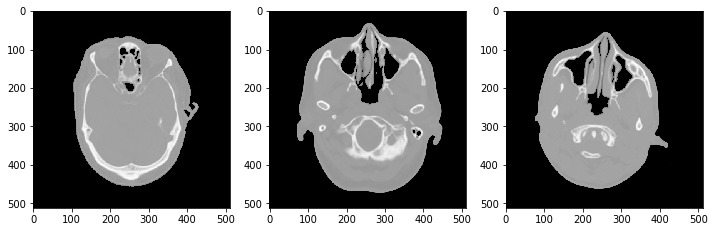

In [19]:
plt.figure(figsize=(12, 12))

for index, image_path in enumerate(ct_images[0:3]):
  img = load_image(f'ct-images/{image_path}')
  plt.subplot(1, 3, index + 1)
  plt.imshow(tf.squeeze(img) / img.numpy().max(), cmap='gray')

plt.show()

## MR-Images

In [0]:
!unzip -q MR-folder.zip

In [0]:
mr_folder_name = "MR-folder"

In [0]:
mr_sessions = os.listdir(mr_folder_name)

In [0]:
!mkdir mr-images

In [0]:
for mr_session in mr_sessions:
  path = f'{mr_folder_name}/{mr_session}'
  images_path = os.listdir(path)
  
  for img_path in images_path:
    shutil.move(f'{path}/{img_path}', "mr-images")

In [0]:
mr_images = os.listdir("mr-images")

In [26]:
len(mr_images)

1595

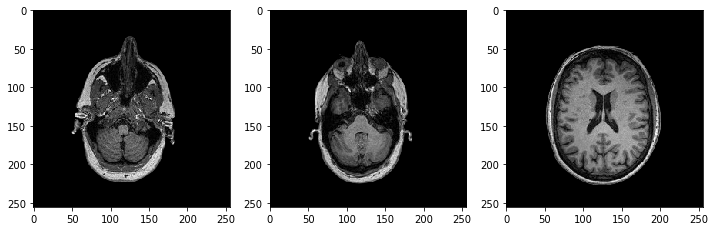

In [27]:
plt.figure(figsize=(12, 12))

for index, image_path in enumerate(mr_images[0:3]):
  img = load_image(f'mr-images/{image_path}')
  plt.subplot(1, 3, index + 1)
  plt.imshow(tf.squeeze(img), cmap='gray')

plt.show()

## PET Images

In [0]:
!unzip -q PET-folder.zip

In [0]:
pet_folder_name = "PET-folder"

In [0]:
pet_sessions = os.listdir(pet_folder_name)

In [0]:
!mkdir pet-images

In [0]:
for pet_session in pet_sessions:
  path = f'{pet_folder_name}/{pet_session}'
  images_path = os.listdir(path)
  
  for img_path in images_path:
    shutil.move(f'{path}/{img_path}', "pet-images")

In [0]:
pet_images = os.listdir("pet-images")

In [32]:
len(pet_images)

1688

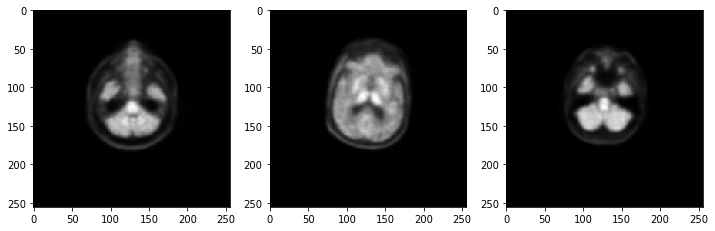

In [33]:
plt.figure(figsize=(12, 12))

for index, image_path in enumerate(pet_images[0:3]):
  img = load_image(f'pet-images/{image_path}')
  plt.subplot(1, 3, index + 1)
  plt.imshow(tf.squeeze(img), cmap='gray')

plt.show()

## Data Generator

In [0]:
padded_size = 286
image_size = 256

In [0]:
@tf.function()
def random_jitter(image):
  padded_image = tf.image.resize(image, [padded_size, padded_size],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  cropped_image = tf.image.random_crop(padded_image, size=[image_size, image_size, 1])

  return cropped_image

In [0]:
def load_train_image(image_path):
  image = load_image(image_path)
  image = random_jitter(image)
  image = (image / 127.5) - 1

  return image

In [0]:
def load_test_image(image_path):
  image = load_image(image_path)
  image = tf.image.resize(image, [image_size, image_size],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = (image / 127.5) - 1

  return image

### CT Generator

In [0]:
batch_size = 1

In [0]:
ct_train_images = [f'ct-images/{img_path}' for img_path in ct_images[160:]]
ct_test_images = [f'ct-images/{img_path}' for img_path in ct_images[:160]]

In [40]:
len(ct_train_images), len(ct_test_images)

(1435, 160)

In [0]:
ct_train_dataset = tf.data.Dataset.list_files(ct_train_images)
ct_train_dataset = ct_train_dataset.map(load_train_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
ct_train_dataset = ct_train_dataset.cache().shuffle(len(ct_train_images))
ct_train_dataset = ct_train_dataset.batch(batch_size)

In [0]:
ct_test_dataset = tf.data.Dataset.list_files(ct_test_images)
ct_test_dataset = ct_test_dataset.map(load_test_image)
ct_test_dataset = ct_test_dataset.batch(batch_size)

### MR Generator

In [0]:
mr_train_images = [f'mr-images/{img_path}' for img_path in mr_images[160:]]
mr_test_images = [f'mr-images/{img_path}' for img_path in mr_images[:160]]

In [44]:
len(mr_train_images), len(mr_test_images)

(1435, 160)

In [0]:
mr_train_dataset = tf.data.Dataset.list_files(mr_train_images)
mr_train_dataset = mr_train_dataset.map(load_train_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
mr_train_dataset = mr_train_dataset.cache().shuffle(len(mr_train_images))
mr_train_dataset = mr_train_dataset.batch(batch_size)

In [0]:
mr_test_dataset = tf.data.Dataset.list_files(mr_test_images)
mr_test_dataset = mr_test_dataset.map(load_test_image)
mr_test_dataset = mr_test_dataset.batch(batch_size)

### PET Generator

In [0]:
pet_train_images = [f'pet-images/{img_path}' for img_path in pet_images[160:1595]]
pet_test_images = [f'pet-images/{img_path}' for img_path in pet_images[:160]]

In [48]:
len(pet_train_images), len(pet_test_images)

(1435, 160)

In [0]:
pet_train_dataset = tf.data.Dataset.list_files(pet_train_images)
pet_train_dataset = pet_train_dataset.map(load_train_image,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
pet_train_dataset = pet_train_dataset.cache().shuffle(len(pet_train_images))
pet_train_dataset = pet_train_dataset.batch(batch_size)

In [0]:
pet_test_dataset = tf.data.Dataset.list_files(pet_test_images)
pet_test_dataset = pet_test_dataset.map(load_test_image)
pet_test_dataset = pet_test_dataset.batch(batch_size)

# Generator Architecture

In [0]:
def encoder_block(layer, number_filters):
  layer = layers.Conv2D(number_filters, 4, strides=2, padding="same", use_bias=False)(layer)
  layer = layers.BatchNormalization()(layer)
  layer = layers.LeakyReLU()(layer)
  
  return layer

In [0]:
def decoder_block(layer, number_filters, connection):
  layer = layers.Conv2DTranspose(number_filters, 4, strides=2, activation='relu', padding='same', use_bias=False)(layer)
  layer = layers.concatenate([layer, connection])

  return layer

In [0]:
def u_net_block(input):
  layer = input
  
  connections = []
  
  for filter_size in encoder_filters_size:
    layer = encoder_block(layer, filter_size)
    connections.append(layer)
  
  layer = connections.pop()
  connections = reversed(connections)
  
  for connection, filter_size in zip(connections, decoder_filters_size):
    layer = decoder_block(layer, filter_size, connection)
  
  output = layers.Conv2DTranspose(1, 4, strides=2, padding='same', activation='tanh')(layer)

  return output

In [0]:
encoder_filters_size = [64, 128, 256, 512, 512, 512, 512, 512]
decoder_filters_size = [512, 512, 512, 512, 256, 128, 64]

In [0]:
def generator_network():
  input = layers.Input(image_shape)
  
  u_block_output = u_net_block(input)
  u_block_output = u_net_block(u_block_output)
  u_block_output = u_net_block(u_block_output)

  model = Model(input, u_block_output)
  
  return model

# Discriminator Architecture

In [0]:
def discriminator_network():
  input = layers.Input(shape=image_shape, name='image')
        
  model = layers.Conv2D(64, 3, strides=2, padding="same")(input)
  model = layers.BatchNormalization()(model)
  model = layers.LeakyReLU()(model)
  
  model = layers.Conv2D(128, 3, strides=2, padding="same")(model)
  model = layers.BatchNormalization()(model)
  model = layers.LeakyReLU()(model)

  model = layers.Conv2D(1, 2, strides=1, activation='sigmoid', padding="valid")(model)

  return Model(inputs=input, outputs=model)

In [0]:
image_shape = (256, 256, 1)

# Training

In [0]:
generator_g = generator_network()
generator_f = generator_network()

In [0]:
discriminator_x = discriminator_network()
discriminator_y = discriminator_network()

## Losses

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss

In [0]:
def discriminator_loss(real, generated):
  real_loss = cross_entropy(tf.ones_like(real), real)
  generated_loss = cross_entropy(tf.zeros_like(generated), generated)

  loss = real_loss + generated_loss

  return loss * 0.5

### Generator Loss

In [0]:
def generator_loss(generated):
  return cross_entropy(tf.ones_like(generated), generated)

### Cycle Loss

In [0]:
lambda_value = 10

In [0]:
def cycle_loss(real_image, cycled_image):
  #The cycled image should be the same as the original image
  loss_l1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return lambda_value * loss_l1

### Identity Loss

In [0]:
def identity_loss(real_image, same_image):
  #The generator_g should output the same image if we use the real image
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  
  return lambda_value * 0.5 * loss

## Optimizers

In [0]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [0]:
checkpoint_dir = "/content/drive/My Drive/training_checkpoints"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

In [193]:
print(tf.train.latest_checkpoint(checkpoint_dir))

/content/drive/My Drive/training_checkpoints/ckpt-4


In [194]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
#tf.train.list_variables(tf.train.latest_checkpoint(checkpoint_dir))

## Train

In [0]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Real Image', 'Generated Image']

  for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(title[i])
    plt.imshow(np.squeeze(display_list[i]) * 0.5 + 0.5, cmap='gray')
    plt.axis('off')
  plt.show()

In [0]:
@tf.function
def train_step(real_image_x, real_image_y):
  with tf.GradientTape(persistent=True) as tape: 
    #generator_g transforms from X to Y
    #generator_f transforms from Y to X

    #From X, generate Y
    generated_image_y = generator_g(real_image_x, training=True)
    #From generated Y, back to X
    cycled_image_x = generator_f(generated_image_y, training=True)

    #From Y, generate X
    generated_image_x = generator_f(real_image_y, training=True)
    #From generated X, back to Y
    cycled_image_y = generator_g(generated_image_x, training=True)

    same_image_x = generator_f(real_image_x, training=True)
    same_image_y = generator_g(real_image_y, training=True)

    #Should output 1's since are real images
    patch_real_x = discriminator_x(real_image_x, training=True)
    patch_real_y = discriminator_y(real_image_y, training=True)

    #Should output 0's since are generated images
    patch_generated_x = discriminator_x(generated_image_x, training=True)
    patch_generated_y = discriminator_y(generated_image_y, training=True)

    generator_g_loss = generator_loss(patch_generated_y)
    generator_f_loss = generator_loss(patch_generated_x)
    
    total_cycle_loss = cycle_loss(real_image_x, cycled_image_x) + cycle_loss(real_image_y, cycled_image_y)
    
    total_generator_g_loss = generator_g_loss + total_cycle_loss + identity_loss(real_image_y, same_image_y)
    total_generator_f_loss = generator_f_loss + total_cycle_loss + identity_loss(real_image_x, same_image_x)

    discriminator_x_loss = discriminator_loss(patch_real_x, patch_generated_x)
    discriminator_y_loss = discriminator_loss(patch_real_y, patch_generated_y)
  
  generator_g_gradients = tape.gradient(total_generator_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_generator_f_loss, generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)
  
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [0]:
epochs = 5

In [0]:
def train(epochs):
  for epoch in range(epochs):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((mr_train_dataset, ct_train_dataset)):
      train_step(image_x, image_y)
      
      if n % 10 == 0:
        print ('.', end='')
      n+=1

    display.clear_output(wait=True)

    for test_image_x in mr_test_dataset.take(5):
      generate_images(generator_g, test_image_x)

    print('Time taken for epoch {} was {} sec\n'.format(epoch + 1, time.time() - start))

  checkpoint.save(file_prefix=checkpoint_prefix)

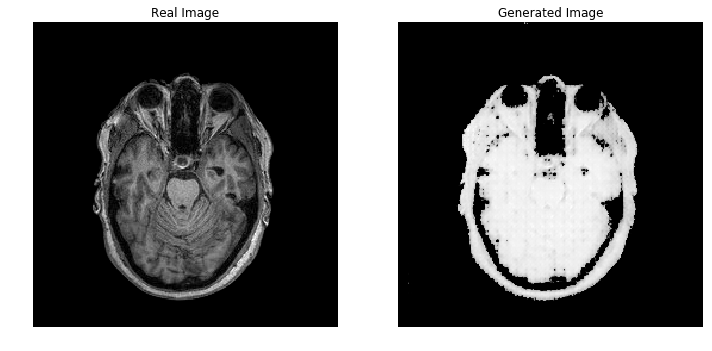

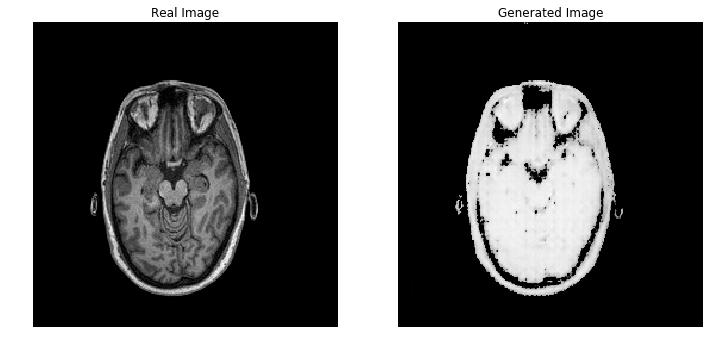

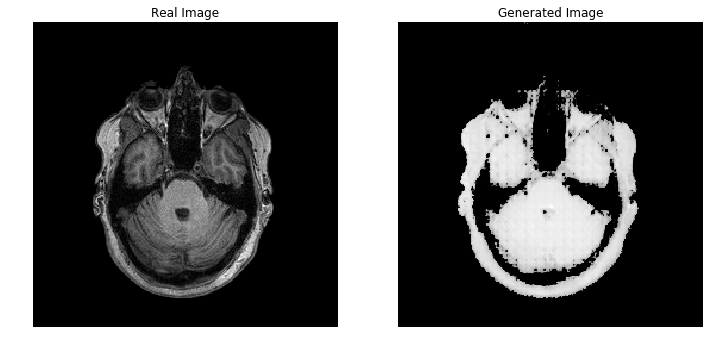

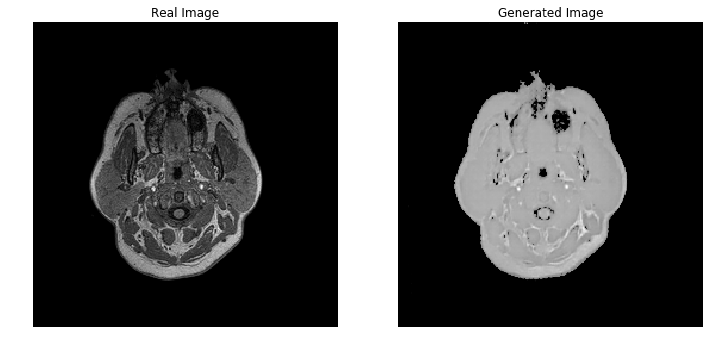

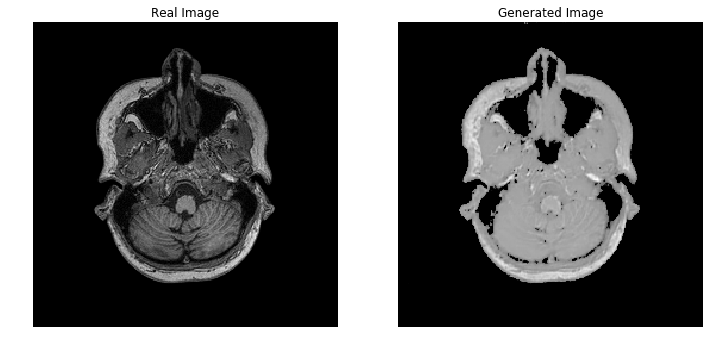

Time taken for epoch 5 was 2831.3210361003876 sec



In [0]:
train(epochs)

In [0]:
!nvidia-smi

Fri Sep 13 20:12:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    71W / 149W |   8394MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Testing MR Images

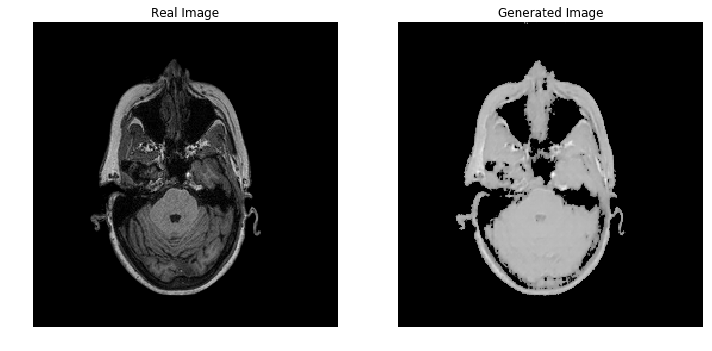

In [84]:
example_img = load_test_image(mr_train_images[1])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

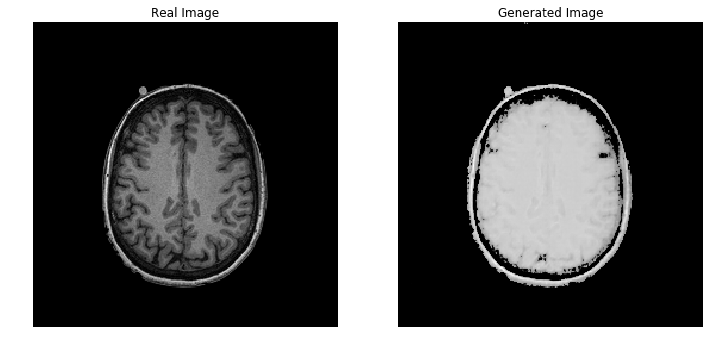

In [86]:
example_img = load_test_image(mr_train_images[7])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

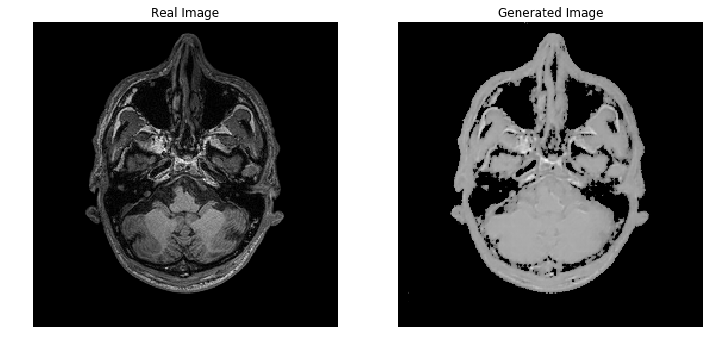

In [87]:
example_img = load_test_image(mr_train_images[12])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

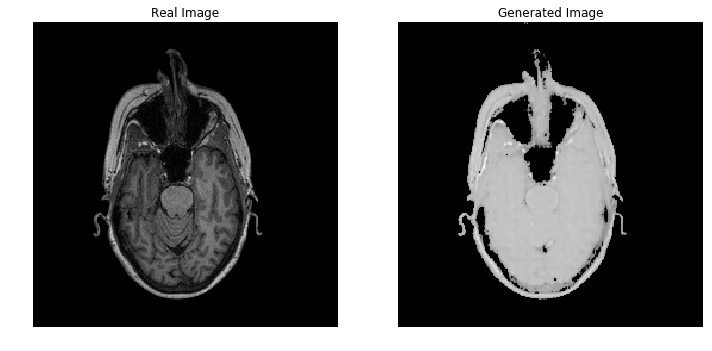

In [94]:
example_img = load_test_image(mr_train_images[33])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

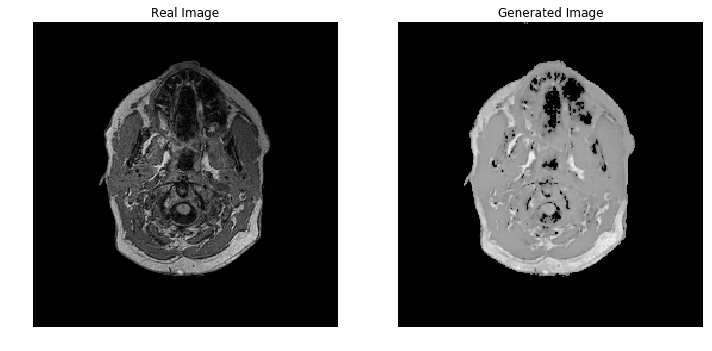

In [99]:
example_img = load_test_image(mr_train_images[46])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

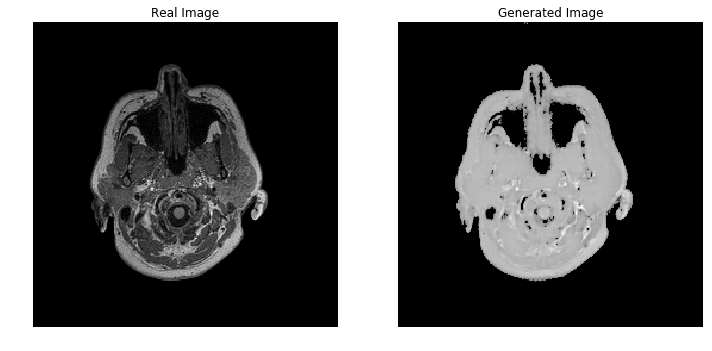

In [100]:
example_img = load_test_image(mr_train_images[49])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

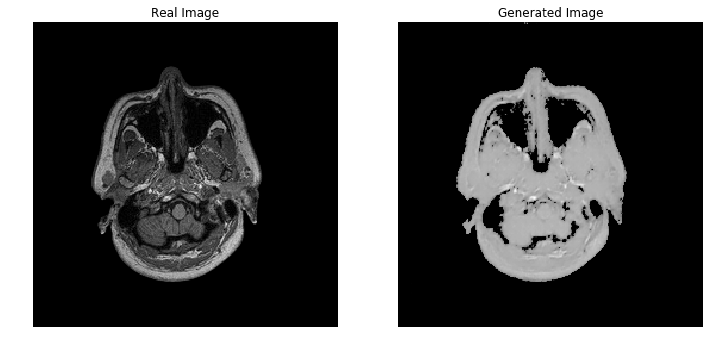

In [164]:
example_img = load_test_image(mr_train_images[16])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

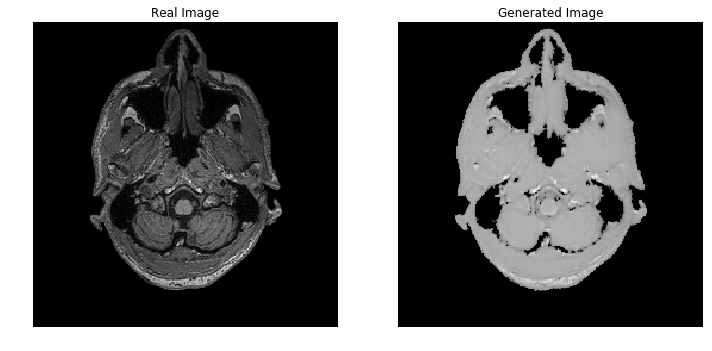

In [165]:
example_img = load_test_image(mr_train_images[53])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

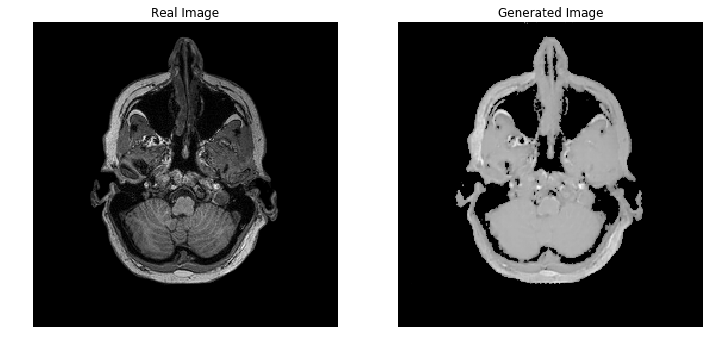

In [167]:
example_img = load_test_image(mr_train_images[69])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

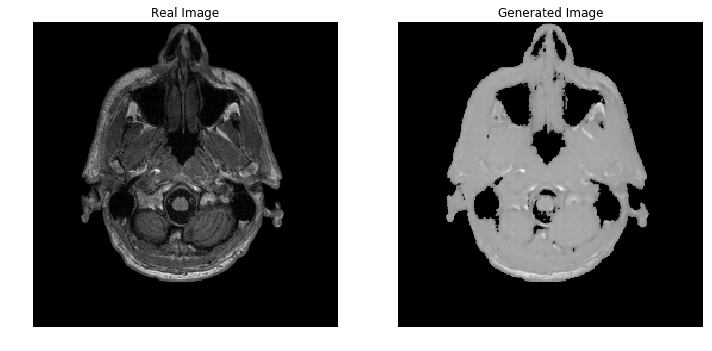

In [168]:
example_img = load_test_image(mr_train_images[101])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

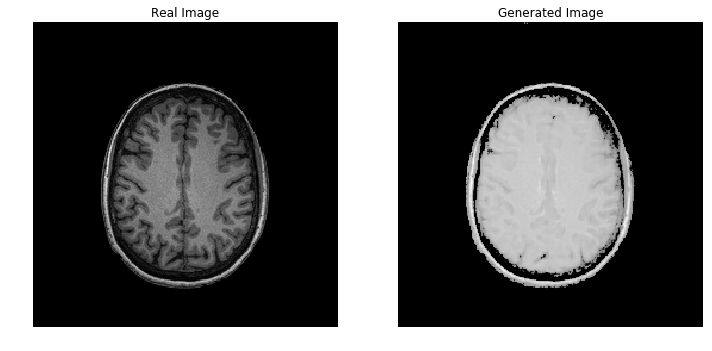

In [169]:
example_img = load_test_image(mr_train_images[111])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

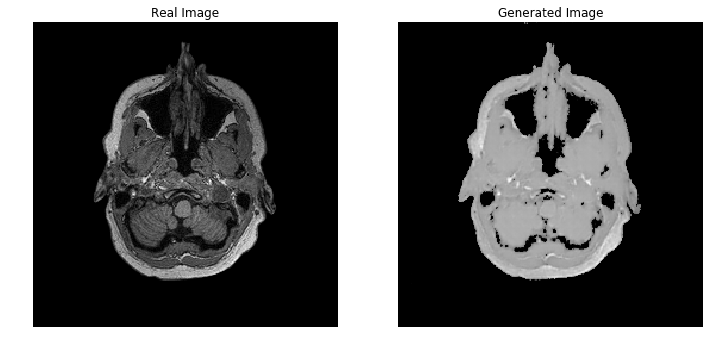

In [171]:
example_img = load_test_image(mr_train_images[115])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

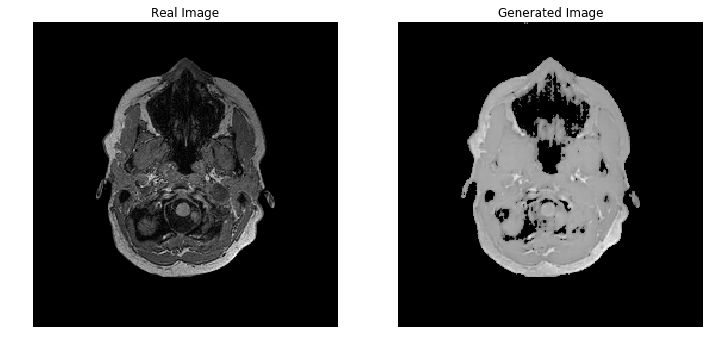

In [190]:
example_img = load_test_image(mr_train_images[325])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

# Testing PET Images

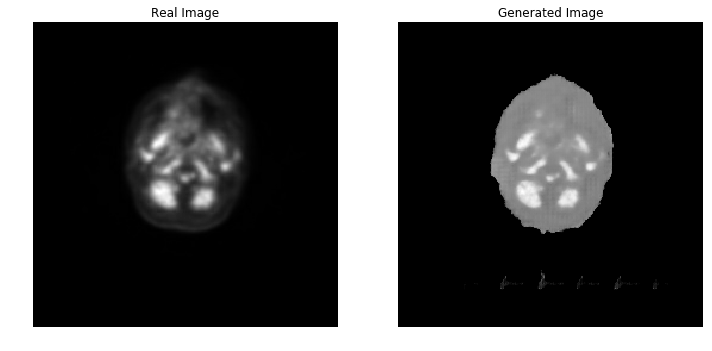

In [203]:
example_img = load_test_image(pet_train_images[100])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

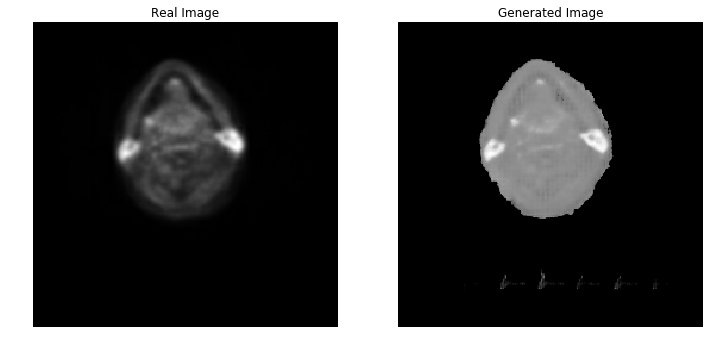

In [204]:
example_img = load_test_image(pet_train_images[200])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

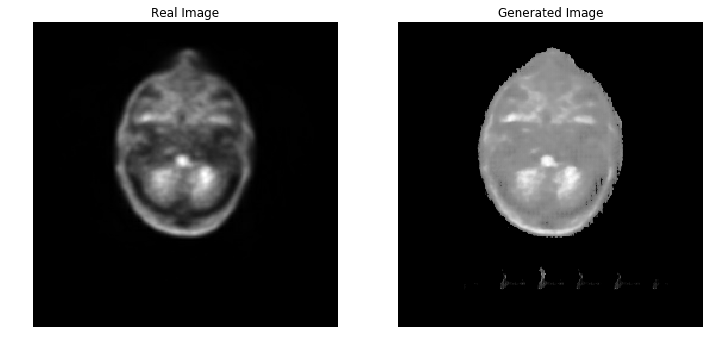

In [206]:
example_img = load_test_image(pet_train_images[250])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

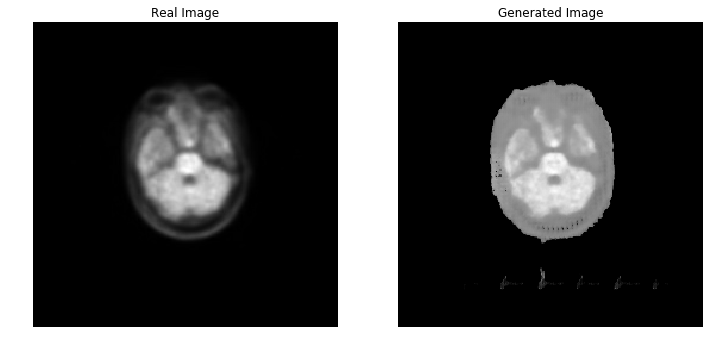

In [207]:
example_img = load_test_image(pet_train_images[240])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

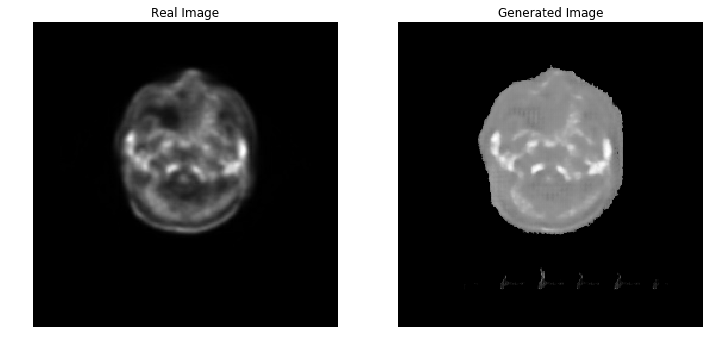

In [208]:
example_img = load_test_image(pet_train_images[350])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

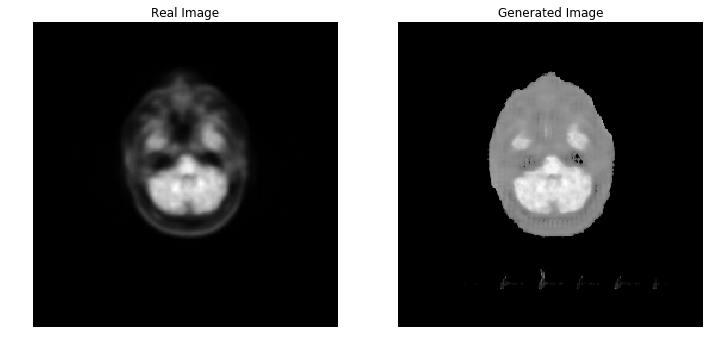

In [209]:
example_img = load_test_image(pet_train_images[400])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

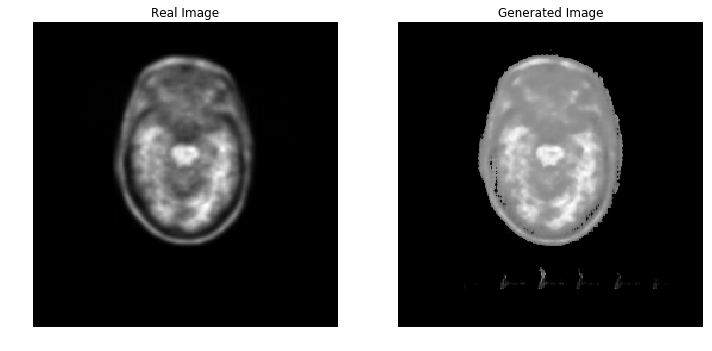

In [210]:
example_img = load_test_image(pet_train_images[450])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

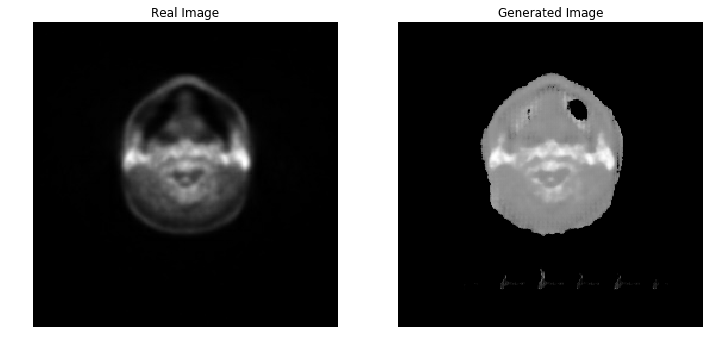

In [211]:
example_img = load_test_image(pet_train_images[410])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

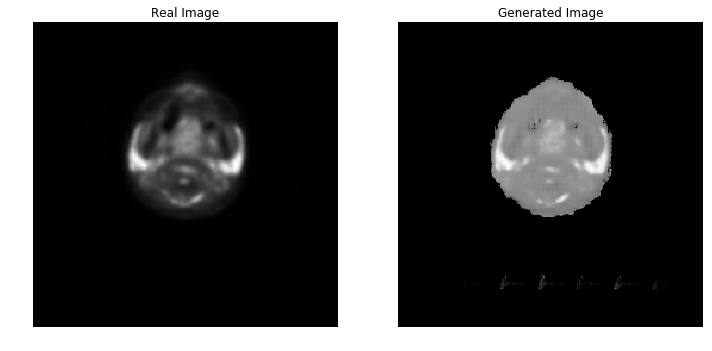

In [212]:
example_img = load_test_image(pet_train_images[415])
generate_images(generator_g, np.expand_dims(example_img, axis=0))

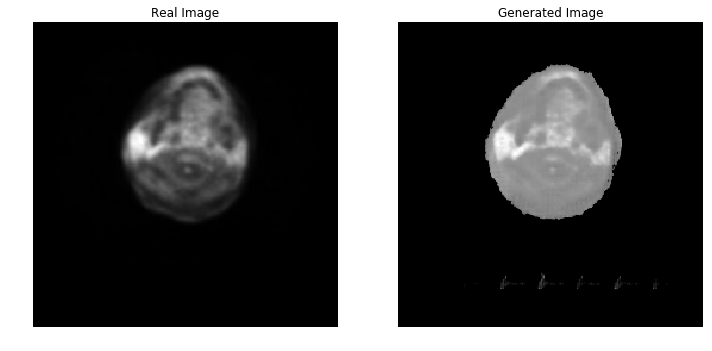

In [213]:
example_img = load_test_image(pet_train_images[420])
generate_images(generator_g, np.expand_dims(example_img, axis=0))